In [23]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

In [30]:
"""
second type of parameters
B_exp = 9
N = 2500
"""

# open data
mechanisms = []
eps_list = [0.5, 1, 1.5]
B_exp = 9
N = 2500

def open_data(folder_name):
    output = {}
    with open(f"{folder_name}/coins.pkl", "rb") as f:
        output["coins"] = pickle.load(f)
    with open(f"{folder_name}/c_list.pkl", "rb") as f:
        output["c_list"] = pickle.load(f)
    return output

for eps in eps_list:
    folder_name = f"results/BaySS_find_constant/N_{N}/B_exp_{B_exp}/eps_{eps:.1f}"
    output = open_data(folder_name)
    output["coins"] = output["coins"].astype(int)
    output["label"] = f"DpBayeSS, eps: {eps}"
    mechanisms.append(output)

def upload_data(N: int, B_exp: int):
    folder_name = f"data/N_{N}/B_exp_{B_exp}"
    output = {}
    # import data
    with open(f'{folder_name}/pareto_data.pkl', 'rb') as f:
        data = pickle.load(f)
    output["data"] = data

    # import bins
    with open(f'{folder_name}/pareto_bins.pkl', 'rb') as f:
        bins = pickle.load(f)
    output["bins"] = bins

    # import intervals
    with open(f'{folder_name}/pareto_intervals.pkl', 'rb') as f:
        intervals = pickle.load(f)
    output["intervals"] = intervals

    # import median
    with open(f'{folder_name}/pareto_median.pkl', 'rb') as f:
        median = pickle.load(f)
    output["median"] = median

    # import median quantile
    with open(f'{folder_name}/pareto_median_quantile.pkl', 'rb') as f:
        median_quantile = pickle.load(f)
    output["median_quantile"] = median_quantile

    # import cdf
    with open(f'{folder_name}/pareto_cdf.pkl', 'rb') as f:
        cf_dict = pickle.load(f)
    output["cf_dict"] = cf_dict

    return output


data = upload_data(N, B_exp)

In [31]:
markers = ["-", "--", "-.", ":", "-o", "-s", "-D", "-^", "-v", "-<", "->", "-p", "-h"]
colors = ["blue", "red", "green", "orange", "purple", "black", "brown", "pink", "gray", "olive", "cyan", "magenta"]

# Success rate

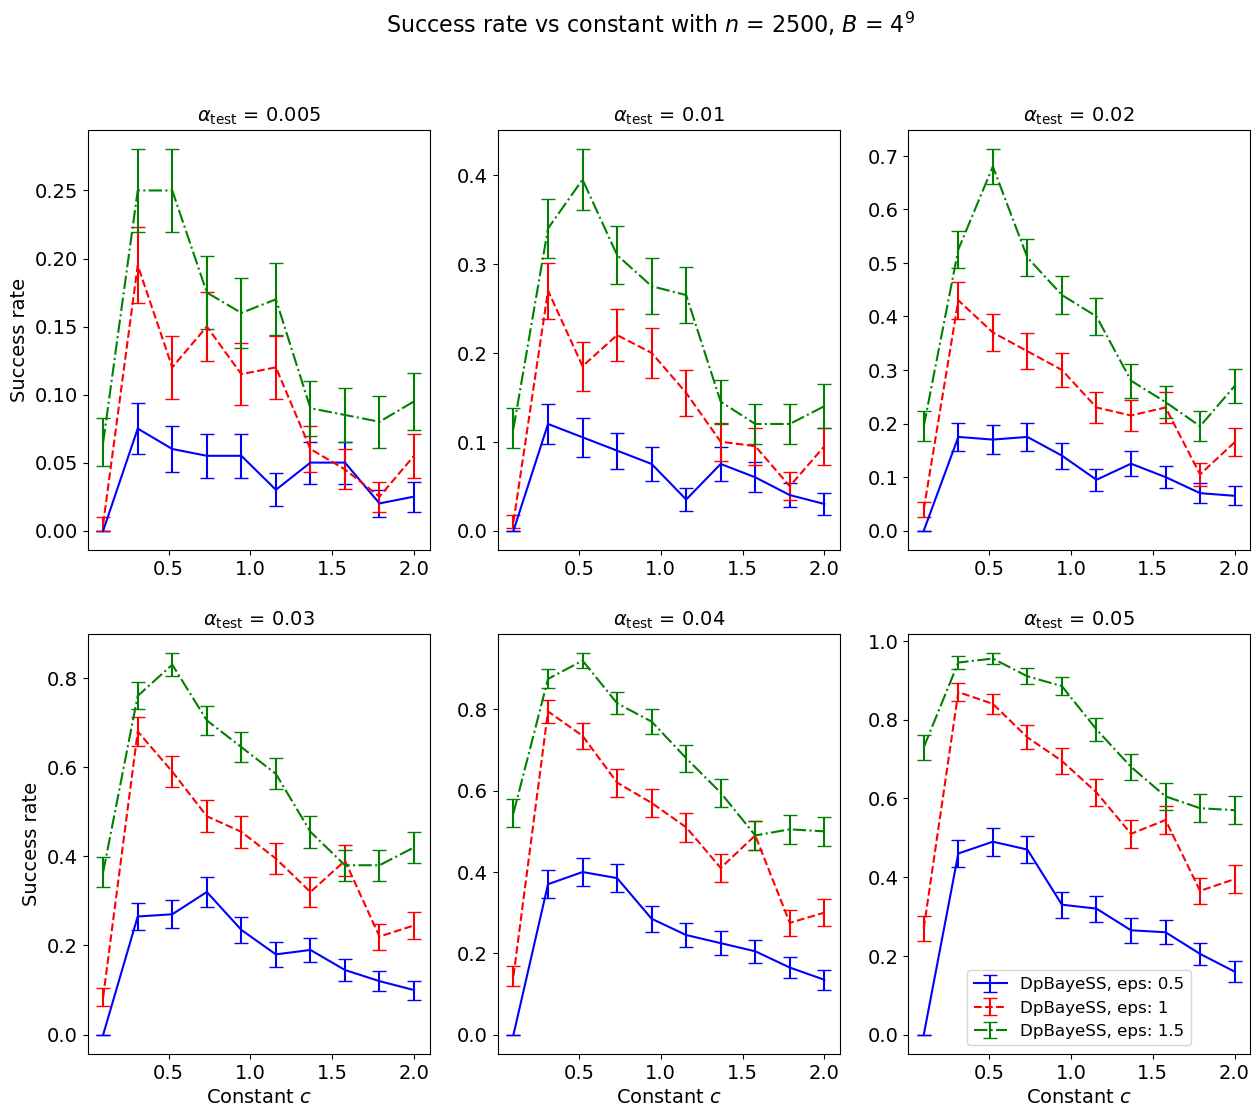

In [32]:
from metrics import get_success

def get_binomial_std(p, n):
    return np.sqrt(p * (1 - p) / n)

fig, axs = plt.subplots(2, 3, figsize=(15, 12))
alpha_test_list = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]

for fig_index, alpha_test in enumerate(alpha_test_list):
    ax = axs[fig_index // 3, fig_index % 3]  # Access subplot correctly
    for i, output in enumerate(mechanisms):
        c_list = output["c_list"]
        coins = output["coins"]
        success = np.zeros((len(c_list), len(coins[0])))
        for j in range(len(c_list)):
            for c, coin in enumerate(coins[j]):
                success[j, c] = get_success(value=coin, alpha=alpha_test, cdf=data["cf_dict"])
        ax.errorbar(c_list,
                    np.mean(success, axis=1),
                    yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]),
                    fmt=markers[i],
                    label=output["label"],
                    color=colors[i],
                    capsize=5)
    if fig_index % 3 == 0:
        ax.set_ylabel("Success rate", fontsize=14)
    if fig_index >= 3:
        ax.set_xlabel(r"Constant $c$", fontsize=14)
    ax.set_title(r"$\alpha_{\text{test}}$ = " + str(alpha_test), fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14) 

fig.suptitle(fr"Success rate vs constant with $n$ = {N}, $B$ = $4^{B_exp}$", fontsize=16)
plt.legend(fontsize=12)

# save fig
folder_name = "find_constant"
os.makedirs(f"figures/{folder_name}", exist_ok=True)
plt.savefig(f"figures/{folder_name}/success_vs_constant_N_{N}_Bexp_{B_exp}.pdf")
plt.show()

# Selected plots

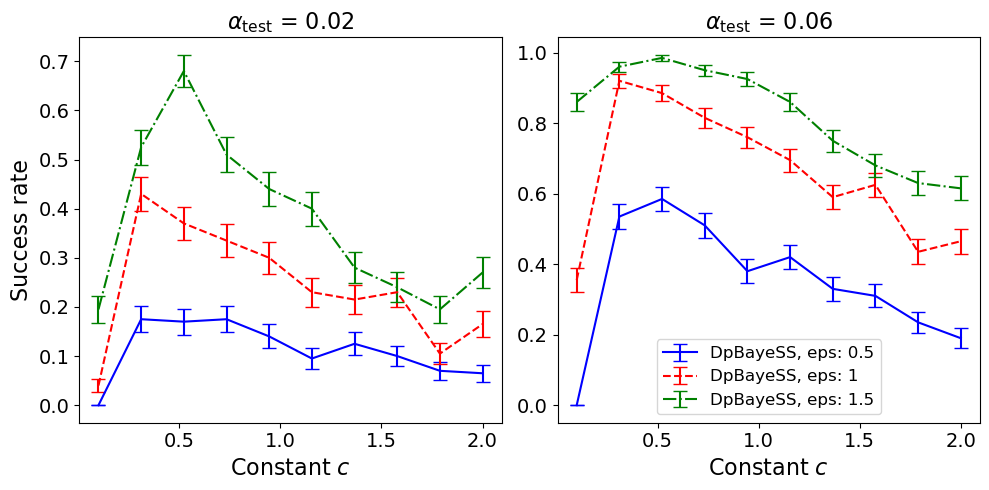

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

alpha_test_list = [0.02, 0.06]

fig_count = 0
for alpha_test in alpha_test_list:
    ax = axs[fig_count]  # Access subplot correctly
    for i, output in enumerate(mechanisms):
        c_list = output["c_list"]
        coins = output["coins"]
        success = np.zeros((len(c_list), len(coins[0])))
        for j in range(len(c_list)):
            for c, coin in enumerate(coins[j]):
                success[j, c] = get_success(value=coin, alpha=alpha_test, cdf=data["cf_dict"])
        ax.errorbar(c_list,
                    np.mean(success, axis=1),
                    yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]),
                    fmt=markers[i],
                    label=output["label"],
                    color=colors[i],
                    capsize=5)
    if fig_count == 0:
        ax.set_ylabel("Success rate", fontsize=16)
    ax.set_xlabel(r"Constant $c$", fontsize=16)
    ax.set_title(r"$\alpha_{\text{test}}$ = " + str(alpha_test), fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14) 
    fig_count += 1

# legend
fig.tight_layout(rect=[0, 0, 1, 1])
plt.legend(fontsize=12)
# save fig
folder_name = "selected_plot/find_constant"
os.makedirs(f"figures/{folder_name}", exist_ok=True)
plt.savefig(f"figures/{folder_name}/success_vs_constant_N_{N}_Bexp_{B_exp}.pdf")
plt.show()

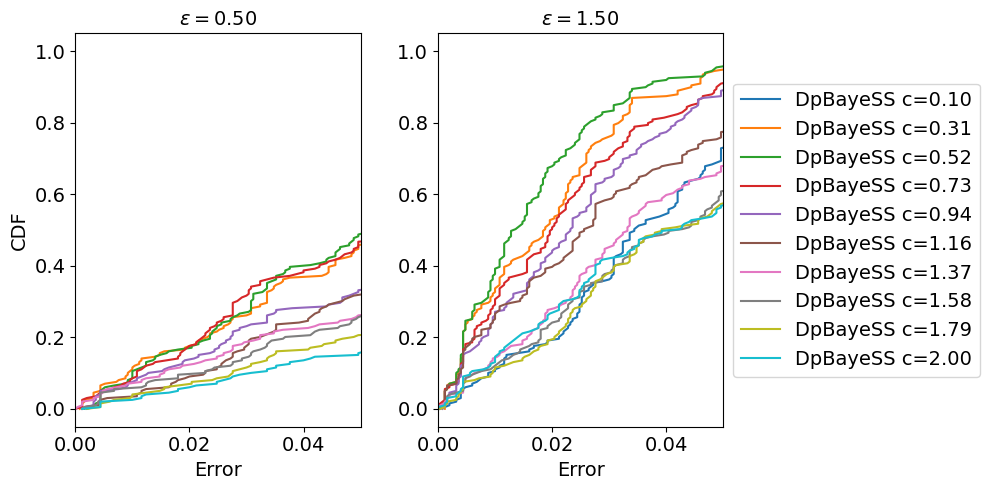

In [34]:
from metrics import get_quantile_absolute_error

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
eps_list = [0.5, 1.5]
for fig_index, eps in enumerate(eps_list):
    ax = axs[fig_index]  # Access subplot correctly
    
    folder_name = f"results/BaySS_find_constant/N_{N}/B_exp_{B_exp}/eps_{eps:.1f}"
    output = open_data(folder_name)
    output["coins"] = output["coins"].astype(int)

    for i, c in enumerate(output["c_list"]):
        # compute error
        error = np.zeros(len(output["coins"][i]))
        for j, coin in enumerate(output["coins"][i]):
            error[j] = get_quantile_absolute_error(coin, data["median"], data["cf_dict"])
        # get cumulative
        error = np.sort(np.abs(error))
        error = error[::-1]
        ax.plot(error, np.linspace(1, 0, len(error)), label=f"DpBayeSS c={c:.2f}")
    ax.set_xlabel('Error', fontsize=14)
    if fig_index == 0:
        ax.set_ylabel('CDF', fontsize=14)
    ax.set_title(fr"$\varepsilon = {eps:.2f}$", fontsize=14)
    ax.set_xlim(0, 0.05)
    ax.tick_params(axis='both', which='major', labelsize=14)  


plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout(rect=[0, 0, 1, 1])

# save fig
folder_name = "selected_plot/find_constant"
os.makedirs(f"figures/{folder_name}", exist_ok=True)
plt.savefig(f"figures/{folder_name}/abs_errors_cdf_N_{N}_Bexp_{B_exp}.pdf")
plt.show()

# CDF of errors

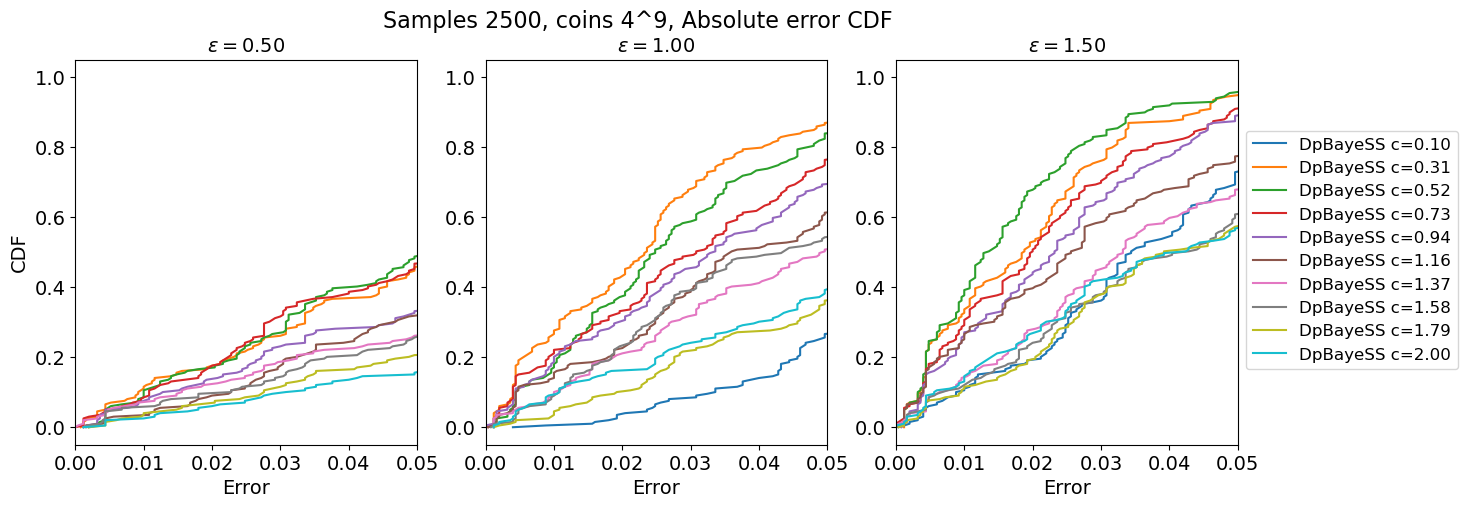

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
eps_list = [0.5, 1, 1.5]
for fig_index, eps in enumerate(eps_list):
    ax = axs[fig_index]  # Access subplot correctly
    
    output = mechanisms[fig_index]
    c_list = output["c_list"]
    for i, c in enumerate(c_list):
        # compute error
        error = np.zeros(len(output["coins"][i]))
        for j, coin in enumerate(output["coins"][i]):
            error[j] = get_quantile_absolute_error(coin, data["median"], data["cf_dict"])
        error = np.sort(np.abs(error))
        error = error[::-1]
        ax.plot(error, np.linspace(1, 0, len(error)), label=f"DpBayeSS c={c:.2f}")
    ax.set_xlabel('Error', fontsize=14)
    if fig_index == 0:
        ax.set_ylabel('CDF', fontsize=14)
    ax.set_title(fr"$\varepsilon = {eps:.2f}$", fontsize=14)
    ax.set_xlim(0, 0.05)
    ax.tick_params(axis='both', which='major', labelsize=14) 

handles, labels = ax.get_legend_handles_labels()
fig.suptitle(f"Samples {N}, coins 4^{B_exp}, Absolute error CDF", fontsize=16)
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=12)

# save fig
folder_name = "find_constant"
os.makedirs(f"figures/{folder_name}", exist_ok=True)
plt.savefig(f"figures/{folder_name}/abs_errors_cdf_N_{N}_Bexp_{B_exp}.pdf", bbox_inches='tight')

plt.show()